In [20]:
import numpy as np
import matplotlib.pyplot as plt

def american_option_fd(
    S0, K, r, sigma, T,
    Smax, M, N,
    option_type="put"
):
    """
    Price an American call or put option using an implicit finite difference method.

    Black–Scholes PDE (for V(t,S)):
        dV/dt + 0.5*sigma^2*S^2*d^2V/dS^2 + r*S*dV/dS - r*V = 0
    For an American option, we enforce V >= payoff(S) at each time step (early exercise).

    Parameters:
        S0 : float
            Current (initial) stock price.
        K : float
            Strike price.
        r : float
            Risk-free interest rate.
        sigma : float
            Volatility (annual).
        T : float
            Time to maturity (in years).
        Smax : float
            Maximum stock price on the grid (should be large enough so option is near zero at Smax).
        M : int
            Number of price steps in the spatial grid (S direction).
        N : int
            Number of time steps.
        option_type : str
            "put" or "call".

    Returns:
        (option_value, S_grid, V) : (float, numpy.ndarray, numpy.ndarray)
            option_value : Interpolated FD value at S0 (time 0).
            S_grid : The array of stock prices from 0..Smax.
            V : The option values at t=0 for each stock price in S_grid.
    """
    # Grid spacing
    dS = Smax / M
    dt = T / N

    # Stock price grid
    S_grid = np.linspace(0, Smax, M + 1)

    # Payoff function at maturity
    if option_type.lower() == "put":
        payoff = np.maximum(K - S_grid, 0.0)
    elif option_type.lower() == "call":
        payoff = np.maximum(S_grid - K, 0.0)
    else:
        raise ValueError("option_type must be 'put' or 'call'.")

    # Initialize option values at maturity
    V = payoff.copy()

    # Precompute coefficients for the tridiagonal system
    # For node i, let Si = i * dS.
    # alpha_i = 0.5*sigma^2*(Si^2) / dS^2  => 0.5*sigma^2*(i^2)
    # beta_i = 0.5*r*Si / dS             => 0.5*r*i
    # We'll build them on the fly inside the loop for clarity.

    for n in range(N):
        # We'll solve A * V_new = V_old (implicit in time).
        A = np.zeros(M - 1)
        B = np.zeros(M - 1)
        C = np.zeros(M - 1)
        D = np.zeros(M - 1)

        for i in range(1, M):
            Si = i * dS
            alpha = 0.5 * sigma**2 * (i**2)
            beta = 0.5 * r * i

            # Coefficients for the implicit scheme
            #  V_{i}^{n} - dt[alpha(V_{i+1}^{n}-2V_{i}^{n}+V_{i-1}^{n}) + beta(V_{i+1}^{n}-V_{i-1}^{n}) + rV_{i}^{n}]
            # Rewriting leads to a tridiagonal system for V_{i}^{n+1}.

            A[i - 1] = -dt * (alpha - beta)
            B[i - 1] = 1 + dt * (2*alpha + r)
            C[i - 1] = -dt * (alpha + beta)
            D[i - 1] = V[i]  # Right-hand side from previous time layer

        # Boundary conditions:
        # For an American put:
        #   V(0,t) = K (since payoff is K - 0 = K if you exercise at S=0)
        #   V(Smax,t) ~ 0 if Smax >> K
        # For an American call:
        #   V(0,t) ~ 0
        #   V(Smax,t) ~ Smax - K if Smax >> K
        # We'll incorporate V(0) and V(M) into D.

        # i=1 depends on V(0), i=M-1 depends on V(M).
        # For i=1:
        D[0] -= A[0] * V[0]
        # For i=M-1:
        #   V(M)= boundary, multiply by C[M-2], but boundary is V[M].
        D[-1] -= C[-1] * V[M]

        # Solve the tridiagonal system using Thomas algorithm
        # 1) Forward elimination
        for i in range(1, M - 1):
            factor = A[i] / B[i - 1]
            B[i] -= factor * C[i - 1]
            D[i] -= factor * D[i - 1]

        # 2) Back substitution
        V_new = np.zeros(M - 1)
        V_new[-1] = D[-1] / B[-1]
        for i in range(M - 3, -1, -1):
            V_new[i] = (D[i] - C[i] * V_new[i + 1]) / B[i]

        # Update interior points
        V[1:M] = V_new

        # Enforce early exercise condition
        if option_type.lower() == "put":
            V = np.maximum(V, K - S_grid)  # American put payoff
        else:  # call
            V = np.maximum(V, S_grid - K)  # American call payoff

        # Reapply boundary conditions
        if option_type.lower() == "put":
            V[0] = K
            V[-1] = 0.0
        else:  # call
            V[0] = 0.0
            V[-1] = Smax - K if Smax > K else 0.0

    # Interpolate to find the option value at S0
    option_value = np.interp(S0, S_grid, V)
    return option_value, S_grid, V


In [21]:
def compute_greeks_fd(
    S0, K, r, sigma, T,
    Smax, M, N,
    option_type="put",
    eps=0.1
):
    """
    Compute Greeks using finite differences on the American FD solver.
    """
    # Base price
    V0, _, _ = american_option_fd(S0, K, r, sigma, T, Smax, M, N, option_type)

    # Delta
    V_up, _, _ = american_option_fd(S0 + eps, K, r, sigma, T, Smax, M, N, option_type)
    V_down, _, _ = american_option_fd(S0 - eps, K, r, sigma, T, Smax, M, N, option_type)
    delta = (V_up - V_down) / (2 * eps)

    # Gamma
    gamma = (V_up - 2 * V0 + V_down) / (eps**2)

    # Theta (perturb T)
    T_small = max(T - eps, 1e-6)
    V_T, _, _ = american_option_fd(S0, K, r, sigma, T_small, Smax, M, N, option_type)
    theta = (V_T - V0) / (-eps)

    # Vega (perturb sigma)
    V_up_sigma, _, _ = american_option_fd(S0, K, r, sigma + eps, T, Smax, M, N, option_type)
    V_down_sigma, _, _ = american_option_fd(S0, K, r, sigma - eps, T, Smax, M, N, option_type)
    vega = (V_up_sigma - V_down_sigma) / (2 * eps)

    # Rho (perturb r)
    V_up_r, _, _ = american_option_fd(S0, K, r + eps, sigma, T, Smax, M, N, option_type)
    V_down_r, _, _ = american_option_fd(S0, K, r - eps, sigma, T, Smax, M, N, option_type)
    rho = (V_up_r - V_down_r) / (2 * eps)

    return {
        "Price": V0,
        "Delta": delta,
        "Gamma": gamma,
        "Theta": theta,
        "Vega": vega,
        "Rho": rho
    }


In [22]:
def plot_price_vs_time_fd(
    S0, K, r, sigma,
    T_max, Smax, M, N,
    option_type="put"
):
    """
    Plot American option price vs. time to maturity using the FD method.
    """
    times = np.linspace(0.01, T_max, 20)  # from near 0 to T_max
    prices = []
    for T_ in times:
        V, _, _ = american_option_fd(S0, K, r, sigma, T_, Smax, M, N, option_type)
        prices.append(V)

    plt.figure(figsize=(8,6))
    plt.plot(times, prices, marker='o', label=f"American {option_type.title()} (FD)")
    plt.xlabel("Time to Maturity")
    plt.ylabel("Option Price")
    plt.title(f"American {option_type.title()} Price vs. Time (Finite Difference)")
    plt.grid(True)
    plt.legend()
    plt.show()


American Put (Finite Difference) Greeks:
Price: 6.0810
Delta: -0.4165
Gamma: 0.0000
Theta: 2.2289
Vega: 37.4174
Rho: -30.2773


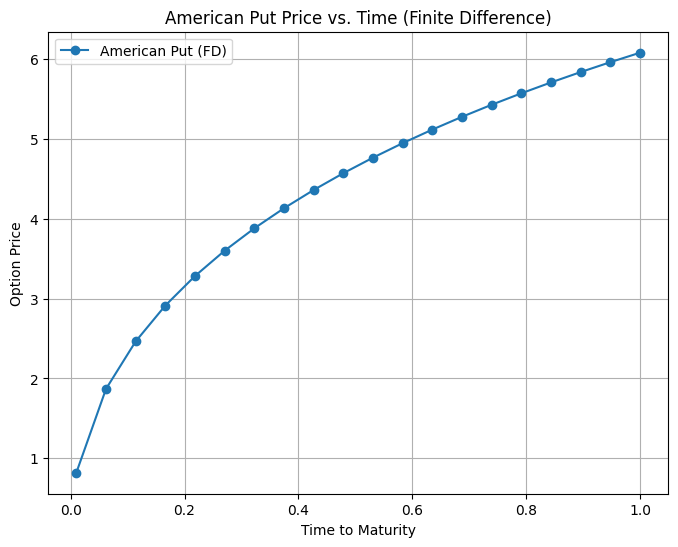

In [23]:
if __name__ == "__main__":
    # Parameters
    S0 = 100
    K = 100
    r = 0.05
    sigma = 0.2
    T = 1.0

    # FD grid parameters
    Smax = 3 * S0  # pick a maximum price for the grid
    M = 200        # number of price steps
    N = 200        # number of time steps

    # Choose option type: "put" or "call"
    option_type = "put"

    # 1) Compute Price & Greeks
    greeks_fd = compute_greeks_fd(S0, K, r, sigma, T, Smax, M, N, option_type, eps=.001)
    print(f"American {option_type.title()} (Finite Difference) Greeks:")
    for g, val in greeks_fd.items():
        print(f"{g}: {val:.4f}")

    # 2) Plot Price vs. Time to Maturity
    plot_price_vs_time_fd(S0, K, r, sigma, T, Smax, M, N, option_type)


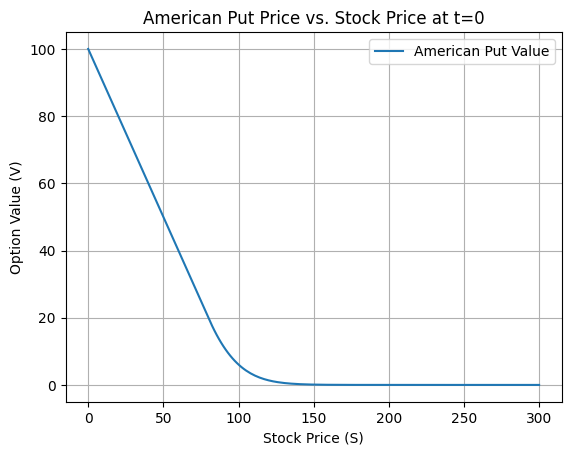

In [27]:
import matplotlib.pyplot as plt

# Use the same american_option_fd function you shared
option_value, S_grid, V = american_option_fd(
    S0=100, K=100, r=0.05, sigma=0.2, T=1.0,
    Smax=300, M=200, N=200, option_type="put"
)

plt.plot(S_grid, V, label="American Put Value")
plt.xlabel("Stock Price (S)")
plt.ylabel("Option Value (V)")
plt.title("American Put Price vs. Stock Price at t=0")
plt.grid(True)
plt.legend()
plt.show()
